# Studi Kasus Ketiga: Computer Vision
Model klasifikasi gambar dengan teknik CNN menggunakan dataset rambu lalu lintas.  
Sumber data: [German Traffic Sign Dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) atau [berikut](https://www.kaggle.com/datasets/saadhaxxan/germantrafficsigns).

## Data Understanding

Dataset ini memiliki komponen sebagai berikut:

- Data untuk permasalahan klasifikasi gambar tunggal dengan banyak kelas.
- Terdiri dari 43 kelas, artinya ada 43 jenis rambu lalu lintas.
- Memiliki total lebih dari 50.000 gambar.
- Data diambil dari foto rambu yang sebenarnya (bukan sintetis).



Deskripsi variabel

| Indeks Kelas | Keterangan Label                                      | Indeks Kelas | Keterangan Label                                    |
|--------|------------------------------------------------------|--------------|-----------------------------------------------------|
| 0      | Speed limit (20km/h)                                | 22           | Bumpy road                                          |
| 1      | Speed limit (30km/h)                                | 23           | Slippery road                                      |
| 2      | Speed limit (50km/h)                                | 24           | Road narrows on the right                           |
| 3      | Speed limit (60km/h)                                | 25           | Road work                                           |
| 4      | Speed limit (70km/h)                                | 26           | Traffic signals                                     |
| 5      | Speed limit (80km/h)                                | 27           | Pedestrians                                         |
| 6      | End of speed limit (80km/h)                         | 28           | Children crossing                                    |
| 7      | Speed limit (100km/h)                               | 29           | Bicycles crossing                                   |
| 8      | Speed limit (120km/h)                               | 30           | Beware of ice/snow                                  |
| 9      | No passing                                          | 31           | Wild animals crossing                                |
| 10     | No passing for vehicles over 3.5 metric tons        | 32           | End of all speed and passing limits                 |
| 11     | Right-of-way at the next intersection                | 33           | Turn right ahead                                    |
| 12     | Priority road                                       | 34           | Turn left ahead                                     |
| 13     | Yield                                               | 35           | Ahead only                                          |
| 14     | Stop                                                | 36           | Go straight or right                                |
| 15     | No vehicles                                         | 37           | Go straight or left                                 |
| 16     | Vehicles over 3.5 metric tons prohibited             | 38           | Keep right                                          |
| 17     | No entry                                           | 39           | Keep left                                          |
| 18     | General caution                                     | 40           | Roundabout mandatory                                 |
| 19     | Dangerous curve to the left                          | 41           | End of no passing                                   |
| 20     | Dangerous curve to the right                         | 42           | End of no passing by vehicles over 3.5 metric tons |
| 21     | Double curve                                        |              |                                                     |


## Data Loading

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

>Mount drive manual

In [2]:
## Load the data
training_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/test.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


## EDA

In [3]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [4]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


## Data Preparation


In [5]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


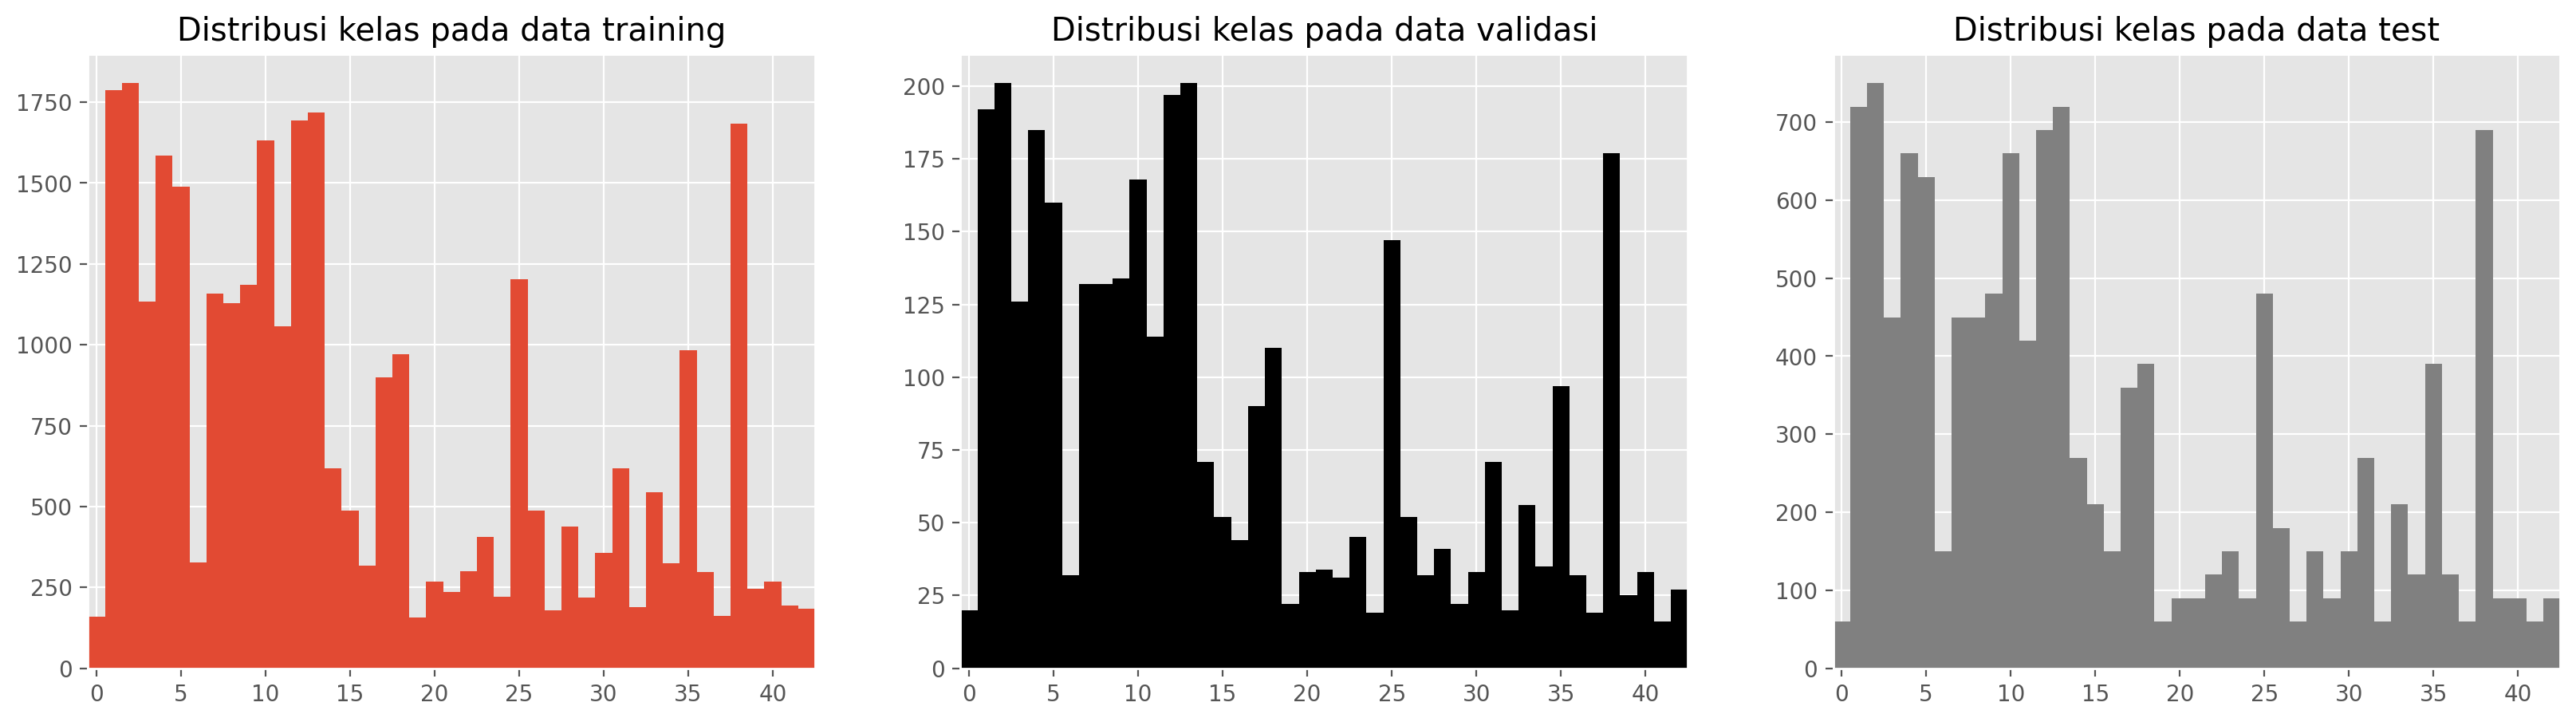

In [6]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [7]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## Modeling (Training)

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [9]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 19s 18ms/step - loss: 1.8121 - accuracy: 0.5503 - val_loss: 0.4243 - val_accuracy: 0.8888
Epoch 2/25
979/979 [==============================] - 17s 18ms/step - loss: 0.5618 - accuracy: 0.8349 - val_loss: 0.2066 - val_accuracy: 0.9451
Epoch 3/25
979/979 [==============================] - 18s 18ms/step - loss: 0.3968 - accuracy: 0.8848 - val_loss: 0.1660 - val_accuracy: 0.9560
Epoch 4/25
979/979 [==============================] - 18s 18ms/step - loss: 0.2875 - accuracy: 0.9141 - val_loss: 0.1059 - val_accuracy: 0.9707
Epoch 5/25
979/979 [==============================] - 18s 18ms/step - loss: 0.2435 - accuracy: 0.9285 - val_loss: 0.0841 - val_accuracy: 0.9761
Epoch 6/25
979/979 [==============================] - 18s 18ms/step - loss: 0.2372 - accuracy: 0.9314 - val_loss: 0.0611 - val_accuracy: 0.9853
Epoch 7/25
979/979 [==============================] - 17s 18ms/step - loss: 0.1891 - accuracy: 0.9468 - val_loss: 0.0636 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


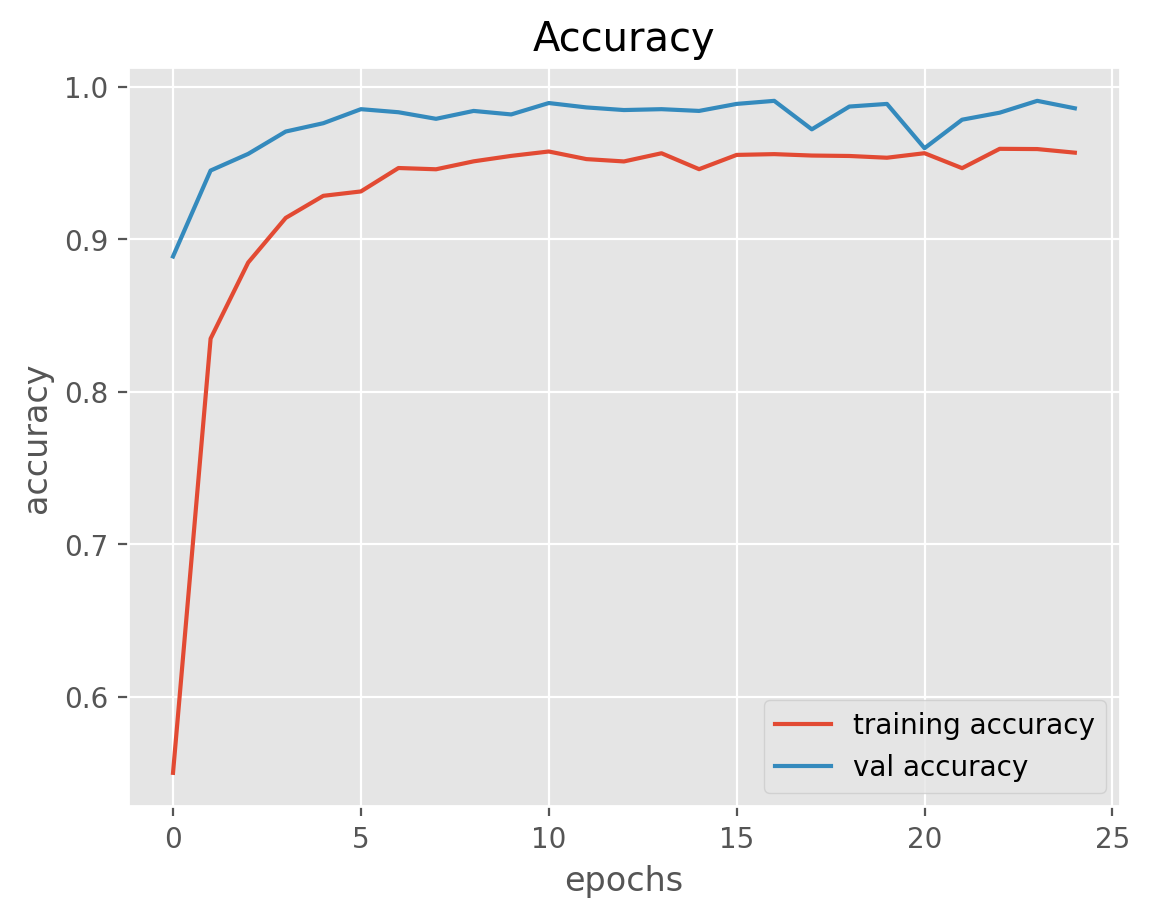

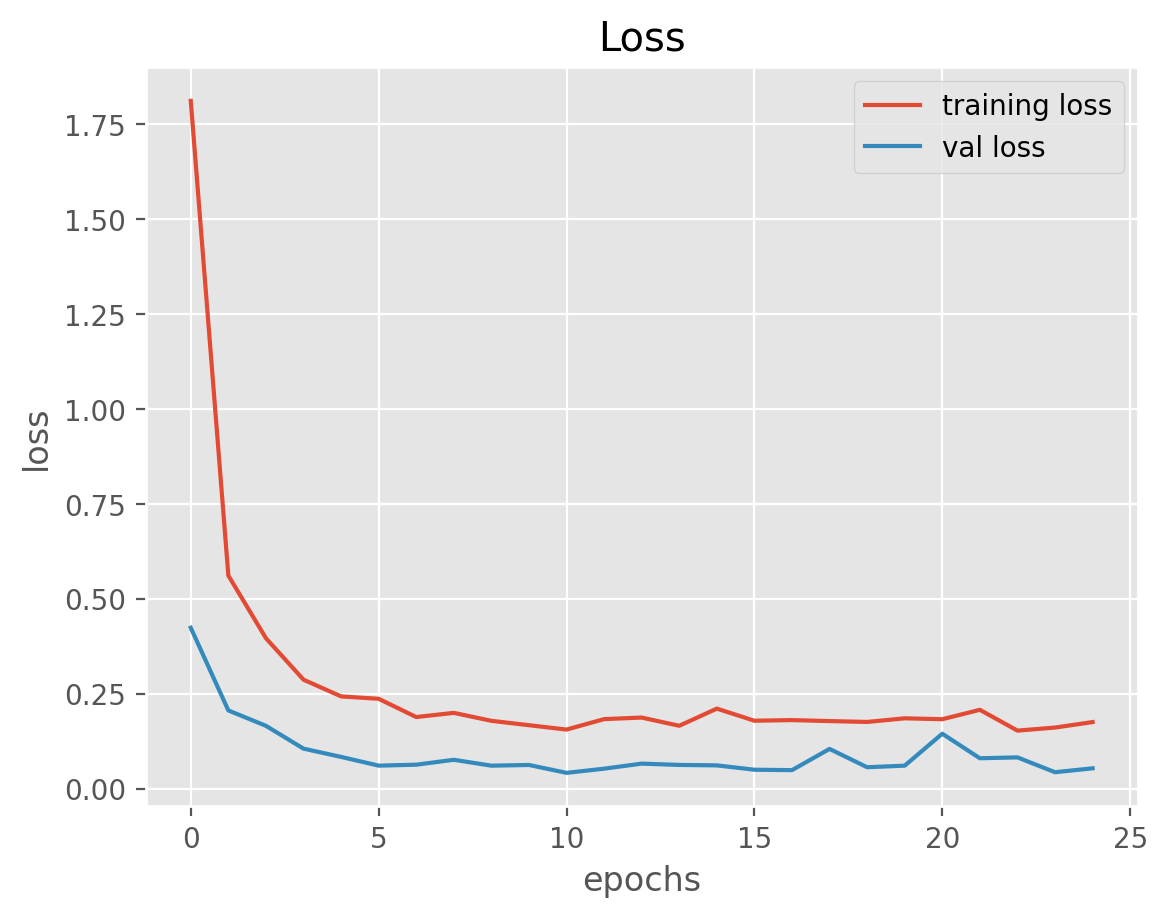

In [11]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluation (Testing)

In [12]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 2s 5ms/step


0.9417260490894696

In [13]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        60
           1       0.90      0.98      0.94       720
           2       0.92      0.99      0.95       750
           3       0.91      0.93      0.92       450
           4       0.97      0.96      0.96       660
           5       0.89      0.89      0.89       630
           6       0.99      0.76      0.86       150
           7       0.97      0.94      0.96       450
           8       0.94      0.96      0.95       450
           9       0.94      0.98      0.96       480
          10       0.98      0.99      0.99       660
          11       0.88      0.91      0.90       420
          12       0.97      0.98      0.98       690
          13       1.00      0.99      1.00       720
          14       0.97      1.00      0.98       270
          15       0.99      0.90      0.94       210
          16       0.98      0.99      0.99       150
          17       0.99    